In [1]:
# Convolutional Neural Network

# Importing the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report

import os
import time
import shutil
import pathlib
import itertools
from PIL import Image


In [2]:
tf.__version__


'2.16.1'

In [3]:
# Part 1 - Data Preprocessing

# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20, # Randomly apply rotations
                                   width_shift_range=0.1, # Randomly apply width shifting
                                   height_shift_range=0.1, # Randomly apply height shifting
                                   shear_range=0.1,   # Randomly apply shearing
                                   zoom_range=0.2,    # Randomly zoom into images
                                   horizontal_flip=True,  # Randomly flip images horizontally
                                   fill_mode='nearest'    # Fill in new pixels in case of rotation or width/height shifts
                                  )

In [4]:
training_set = train_datagen.flow_from_directory('dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 class_mode = 'categorical')

Found 5232 images belonging to 2 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
import warnings
warnings.filterwarnings("ignore") 

In [7]:
from tensorflow.keras.regularizers import l2

In [8]:
### Create Model from scratch using CNN
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dense(2,activation="softmax"))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    25,088,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,100,046 (95.75 MB)

 Trainable params: 25,100,046 (95.75 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    25,088,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,100,046 (95.75 MB)

 Trainable params: 25,100,046 (95.75 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [11]:
r=model.fit(x = training_set, validation_data = test_set, epochs = 15)

Epoch 1/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 1001s 2s/step - accuracy: 0.7979 - loss: 0.5960 - val_accuracy: 0.9054 - val_loss: 0.2385
Epoch 2/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 97s 147ms/step - accuracy: 0.8893 - loss: 0.2689 - val_accuracy: 0.8766 - val_loss: 0.2790
Epoch 3/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 101s 153ms/step - accuracy: 0.9014 - loss: 0.2371 - val_accuracy: 0.9038 - val_loss: 0.2363
Epoch 4/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 92s 140ms/step - accuracy: 0.9121 - loss: 0.2059 - val_accuracy: 0.8670 - val_loss: 0.3590
Epoch 5/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 95s 145ms/step - accuracy: 0.9234 - loss: 0.2013 - val_accuracy: 0.9215 - val_loss: 0.1866
Epoch 6/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 85s 130ms/step - accuracy: 0.9344 - loss: 0.1906 - val_accuracy: 0.8718 - val_loss: 0.3010
Epoch 7/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 86s 130ms/step - accuracy: 0.9294 - loss: 0.1722 - val_accuracy: 0.9263 - val_loss: 0.1901
Epoch 8/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 85s 129ms/step - accuracy: 0.9381 - loss: 0

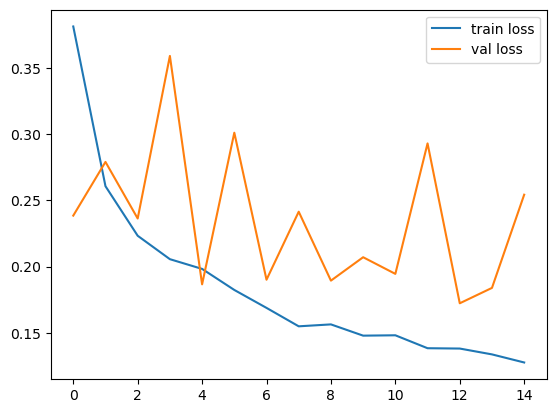

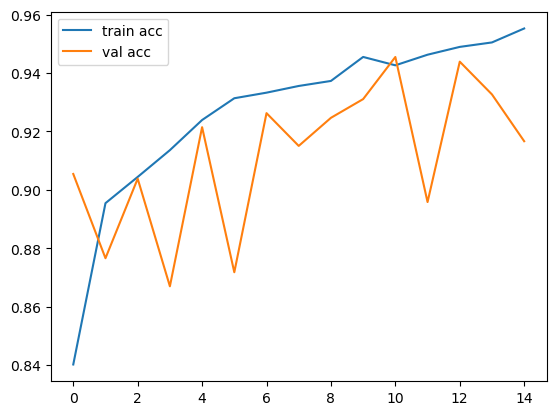

<Figure size 640x480 with 0 Axes>

In [12]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [13]:
from tensorflow.keras.models import load_model

model.save('model_cnn.h5')

In [16]:
from tensorflow.keras.models import load_model
 
# load model
# model = load_model('model_cnn.h5')

In [22]:
y_pred = model.predict(test_set)
print(y_pred)

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step
[[8.1572539e-01 1.8427464e-01]
 [6.1391270e-01 3.8608733e-01]
 [3.6837753e-02 9.6316224e-01]
 ...
 [5.1514697e-03 9.9484861e-01]
 [6.6110596e-07 9.9999928e-01]
 [6.3933700e-01 3.6066306e-01]]


In [23]:
pred = np.argmax(y_pred,axis=1)

In [24]:
pred

array([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,

In [18]:
y_pred = model.predict(test_set)

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step


In [19]:
y_pred

array([[1.5676830e-02, 9.8432320e-01],
       [1.2243575e-03, 9.9877572e-01],
       [6.5119886e-05, 9.9993491e-01],
       ...,
       [2.9089195e-03, 9.9709111e-01],
       [3.1630516e-05, 9.9996847e-01],
       [2.6916817e-04, 9.9973077e-01]], dtype=float32)

In [ ]:
import numpy as np
pred = np.argmax(y_pred)

In [ ]:
pred

In [34]:
from tensorflow.keras.preprocessing import image
img=image.load_img('dataset/test/NORMAL/NORMAL-283245-0001.jpeg',target_size=(224,224))

In [35]:
x=image.img_to_array(img)
x

array([[[33., 33., 33.],
        [43., 43., 43.],
        [45., 45., 45.],
        ...,
        [87., 87., 87.],
        [83., 83., 83.],
        [80., 80., 80.]],

       [[31., 31., 31.],
        [40., 40., 40.],
        [44., 44., 44.],
        ...,
        [84., 84., 84.],
        [79., 79., 79.],
        [81., 81., 81.]],

       [[29., 29., 29.],
        [35., 35., 35.],
        [43., 43., 43.],
        ...,
        [84., 84., 84.],
        [80., 80., 80.],
        [80., 80., 80.]],

       ...,

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]

In [36]:
x.shape

(224, 224, 3)

In [37]:
x=image.img_to_array(img)
x

array([[[33., 33., 33.],
        [43., 43., 43.],
        [45., 45., 45.],
        ...,
        [87., 87., 87.],
        [83., 83., 83.],
        [80., 80., 80.]],

       [[31., 31., 31.],
        [40., 40., 40.],
        [44., 44., 44.],
        ...,
        [84., 84., 84.],
        [79., 79., 79.],
        [81., 81., 81.]],

       [[29., 29., 29.],
        [35., 35., 35.],
        [43., 43., 43.],
        ...,
        [84., 84., 84.],
        [80., 80., 80.],
        [80., 80., 80.]],

       ...,

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]

In [38]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [40]:
model.predict(img_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[1., 0.]], dtype=float32)

In [41]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [42]:
if a ==1:
    print('The Chest - Xray has pneumonia')
else:
    print('The Chest - Xray is normal')

The Chest - Xray is normal


In [43]:
loss, accuracy = model.evaluate(test_set)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9237 - loss: 0.2133
Test Loss: 0.25422748923301697
Test Accuracy: 0.9166666865348816


In [ ]:
RESULTS - 
